In [1]:
%matplotlib inline

from typing import Optional, Union

import os
import sys

import torch
import torchvision
from torch import Tensor
import torch.nn.functional as F
from torchvision.ops import boxes as box_ops
from torchvision.ops.boxes import box_area
from torchvision.ops.roi_align import _bilinear_interpolate, roi_align
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

In [2]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device ', device)

main_dirpath='D:/data/'
tensor_dirpath=os.path.join(main_dirpath, 'mask_rcnn')
original_inputs=torch.load(os.path.join(tensor_dirpath, 'part-backbonefpn-orig_input.pt'), map_location=device, weights_only=True)
tfm_inputs=torch.load(os.path.join(tensor_dirpath, 'part-backbonefpn-transform.pt'), map_location=device, weights_only=False)
proposal_boxes=torch.load(os.path.join(tensor_dirpath, 'part-rpn-proposal_boxes.pt'), map_location=device, weights_only=True)
box_roi_pool=torch.load(os.path.join(tensor_dirpath, 'part-roi_head-box_roi_pool.pt'), map_location=device, weights_only=True)
box_predict_results=torch.load(os.path.join(tensor_dirpath, 'part-roi_head-box_predict.pt'), map_location=device, weights_only=True)
print('box_roi_pool ', box_roi_pool.keys())
print('box_features ', box_roi_pool['box_features'].shape)
print('box_predict_results ', box_predict_results.keys(), [r.keys() for r in box_predict_results['result']])

device  cpu
box_roi_pool  dict_keys(['box_features', 'proposals', 'matched_idxs', 'labels', 'regression_targets'])
box_features  torch.Size([800, 256, 7, 7])
box_predict_results  dict_keys(['result']) [dict_keys(['boxes', 'labels', 'scores']), dict_keys(['boxes', 'labels', 'scores'])]


In [3]:
num_classes=2
# load an instance segmentation model pre-trained on COCO
model=torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT', rpn_pre_nms_top_n_train=800,
        rpn_pre_nms_top_n_test=500,  rpn_post_nms_top_n_train=800,  rpn_post_nms_top_n_test=500, box_detections_per_img=100,
        box_batch_size_per_image =400, rpn_batch_size_per_image=100)
# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features
print('the number of inpute features for classifiers ', in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,  num_classes)

# get the number of input features for the mask classifiers
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
print('the number of input features for mask ', in_features_mask)
hidden_layer=256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# move model to the right device
model.to(device);

the number of inpute features for classifiers  1024
the number of input features for mask  256


[`RoIHeads`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py)

Mask training

In [4]:
print('Has mask ', model.roi_heads.has_mask())
proposals=box_roi_pool['proposals']
matched_idxs=box_roi_pool['matched_idxs']
labels=box_roi_pool['labels']
regression_targets=box_roi_pool['regression_targets']
print('proposals ', type(proposals), [p.shape for p in proposals])
print('matched_idxs ', type(matched_idxs), [m.shape for m in matched_idxs])
print('labels ', type(labels), [l.shape for l in labels])
print('regression_targets ', type(regression_targets), [r.shape for r in regression_targets])

Has mask  True
proposals  <class 'list'> [torch.Size([400, 4]), torch.Size([400, 4])]
matched_idxs  <class 'list'> [torch.Size([400]), torch.Size([400])]
labels  <class 'list'> [torch.Size([400]), torch.Size([400])]
regression_targets  <class 'tuple'> [torch.Size([400, 4]), torch.Size([400, 4])]


In [5]:
# during training only focuses on positive boxes
num_images=len(proposals)
mask_proposals, pos_matched_idxs=[],[]
for img_id in range(num_images):
    pos=torch.nonzero(labels[img_id]>0, as_tuple=True)[0]
    mask_proposals.append(proposals[img_id][pos])
    pos_matched_idxs.append(matched_idxs[img_id][pos])
print('mask_proposals ', [m.shape for m in mask_proposals])
print('pos_matched_idxs ', [p.shape for p in pos_matched_idxs])

mask_proposals  [torch.Size([34, 4]), torch.Size([12, 4])]
pos_matched_idxs  [torch.Size([34]), torch.Size([12])]


[`MultiScaleRoIAlign`](https://github.com/pytorch/vision/blob/main/torchvision/ops/poolers.py)

In [6]:
features=tfm_inputs['out']
print('features ', {k:f.shape for k,f in features.items()})
model.roi_heads.mask_roi_pool

features  {'0': torch.Size([2, 256, 208, 264]), '1': torch.Size([2, 256, 104, 132]), '2': torch.Size([2, 256, 52, 66]), '3': torch.Size([2, 256, 26, 33]), 'pool': torch.Size([2, 256, 13, 17])}


MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)

In [7]:
mask_features_=model.roi_heads.mask_roi_pool(features, mask_proposals, tfm_inputs['tfm_images'].image_sizes)
print(mask_features_.shape) # mask per ROI

torch.Size([46, 256, 14, 14])


In [8]:
model.roi_heads.mask_head

MaskRCNNHeads(
  (0): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [9]:
mask_features=model.roi_heads.mask_head(mask_features_)
print(mask_features.shape, mask_features_.shape)

torch.Size([46, 256, 14, 14]) torch.Size([46, 256, 14, 14])


In [10]:
model.roi_heads.mask_predictor

MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:
mask_logits=model.roi_heads.mask_predictor(mask_features)
print('mask_logits ', mask_logits.shape, mask_logits.min().item(), mask_logits.max().item())

mask_logits  torch.Size([46, 2, 28, 28]) -25.564289093017578 13.916374206542969


In [12]:
gt_masks=[t['masks'] for t in tfm_inputs['tmf_targets']]
gt_labels=[t['labels'] for t in tfm_inputs['tmf_targets']]
print('gt_masks ', [g.shape for g in gt_masks])
print('gt_labels ', [g.shape for g in gt_labels])

gt_masks  [torch.Size([2, 800, 1053]), torch.Size([1, 830, 800])]
gt_labels  [torch.Size([2]), torch.Size([1])]


[`maskrcnn_loss`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L100)

```
rcnn_loss_mask = maskrcnn_loss(mask_logits, mask_proposals, gt_masks, gt_labels, pos_matched_idxs)
```

In [13]:
def project_masks_on_boxes(gt_masks, boxes, matched_idxs, M):
    '''
    Given segmentation masks and the bounding boxes corresponding to the location of the masks in the image, this function
    crops and resizes the masks in the position defined by the boxes. This prepares the masks for them to be fed to the loss
    computation as the targets
    Args:
        gt_masks (Tensor): CxHxW ground truth mask
        boxes (Tensor): Nx4 where N is the number of boxes
        matched_idxs (Tensor): index/identification of each boxes
        M (int): size of feature
    '''
    matched_idxs=matched_idxs.to(dtype=boxes.dtype) # 1D
    rois=torch.cat([matched_idxs[:, None], boxes], dim=1)
    gt_masks=gt_masks[:,None].to(dtype=rois.dtype) # Cx1xHxW are C is the number of boxes that contain masks
    gt_mask_rios=roi_align(gt_masks, rois, (M,M), 1.0) # Nx1xMxM 
    return gt_mask_rios.squeeze(1) # NxMxM


In [14]:
def maskrcnn_loss(mask_logits, proposals, gt_masks, gt_labels, mask_matched_idxs):
    '''
    Args:
        mask_logits (Tensor)
        proposals (list[Tensor])
        gt_masks (list[Tensor])
        gt_labels (list[Tensor])
        mask_matched_idxs (list[Tensor])
    '''
    discretization_size=mask_logits.shape[-1]
    labels=[gt_label[idx] for gt_label, idx in zip(gt_labels, mask_matched_idxs)]
    #mask_targets=[project_masks_on_boxes(m, p, i, discretization_size) for m, p, i in zip(gt_masks, proposals, mask_matched_idxs)]
    mask_targets=[project_masks_on_boxes(gt_mask, boxes, idxs, discretization_size) \
                  for gt_mask, boxes, idxs in zip(gt_masks, proposals, mask_matched_idxs)]

    labels=torch.cat(labels, dim=0) # N
    mask_targets=torch.cat(mask_targets, dim=0) # NxMxM where M is the size of mask equal to mask_logits.shape[-1]
    
    # torch.mean in binary_cross_entropy_with_logits does not accept empty tensors, so handle it separately
    if mask_targets.numel()==0: return 0.

    # select only foreground mask
    estimated_mask_logits=mask_logits[torch.arange(labels.shape[0], device=labels.device), labels]
    mask_loss=F.binary_cross_entropy_with_logits(estimated_mask_logits, mask_targets)
    return mask_loss, torch.sigmoid(estimated_mask_logits), mask_targets

rcnn_loss_mask, predicted_mask, reference_masks = maskrcnn_loss(mask_logits, mask_proposals, gt_masks, gt_labels, pos_matched_idxs)
print('rcnn_loss_mask ', rcnn_loss_mask)
print('predicted_mask ', predicted_mask.shape, predicted_mask.min().item(), predicted_mask.max().item())
print('reference_masks ', reference_masks.shape, reference_masks.min().item(), reference_masks.max().item())

rcnn_loss_mask  tensor(1.3489, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
predicted_mask  torch.Size([46, 28, 28]) 2.323979742868687e-06 0.9999990463256836
reference_masks  torch.Size([46, 28, 28]) 0.0 1.0


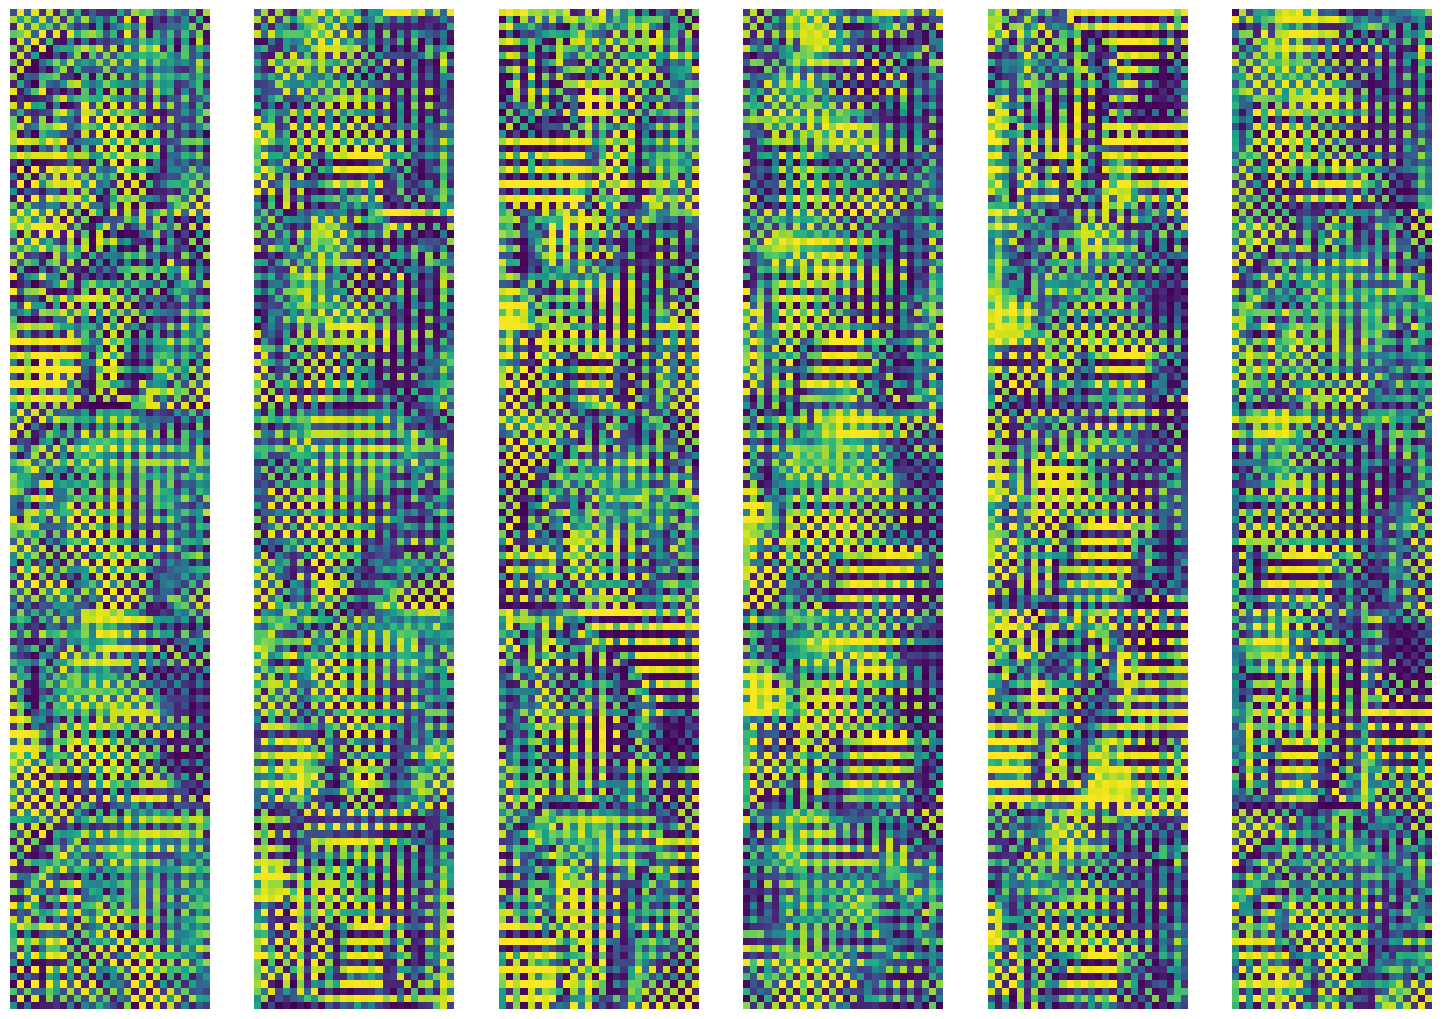

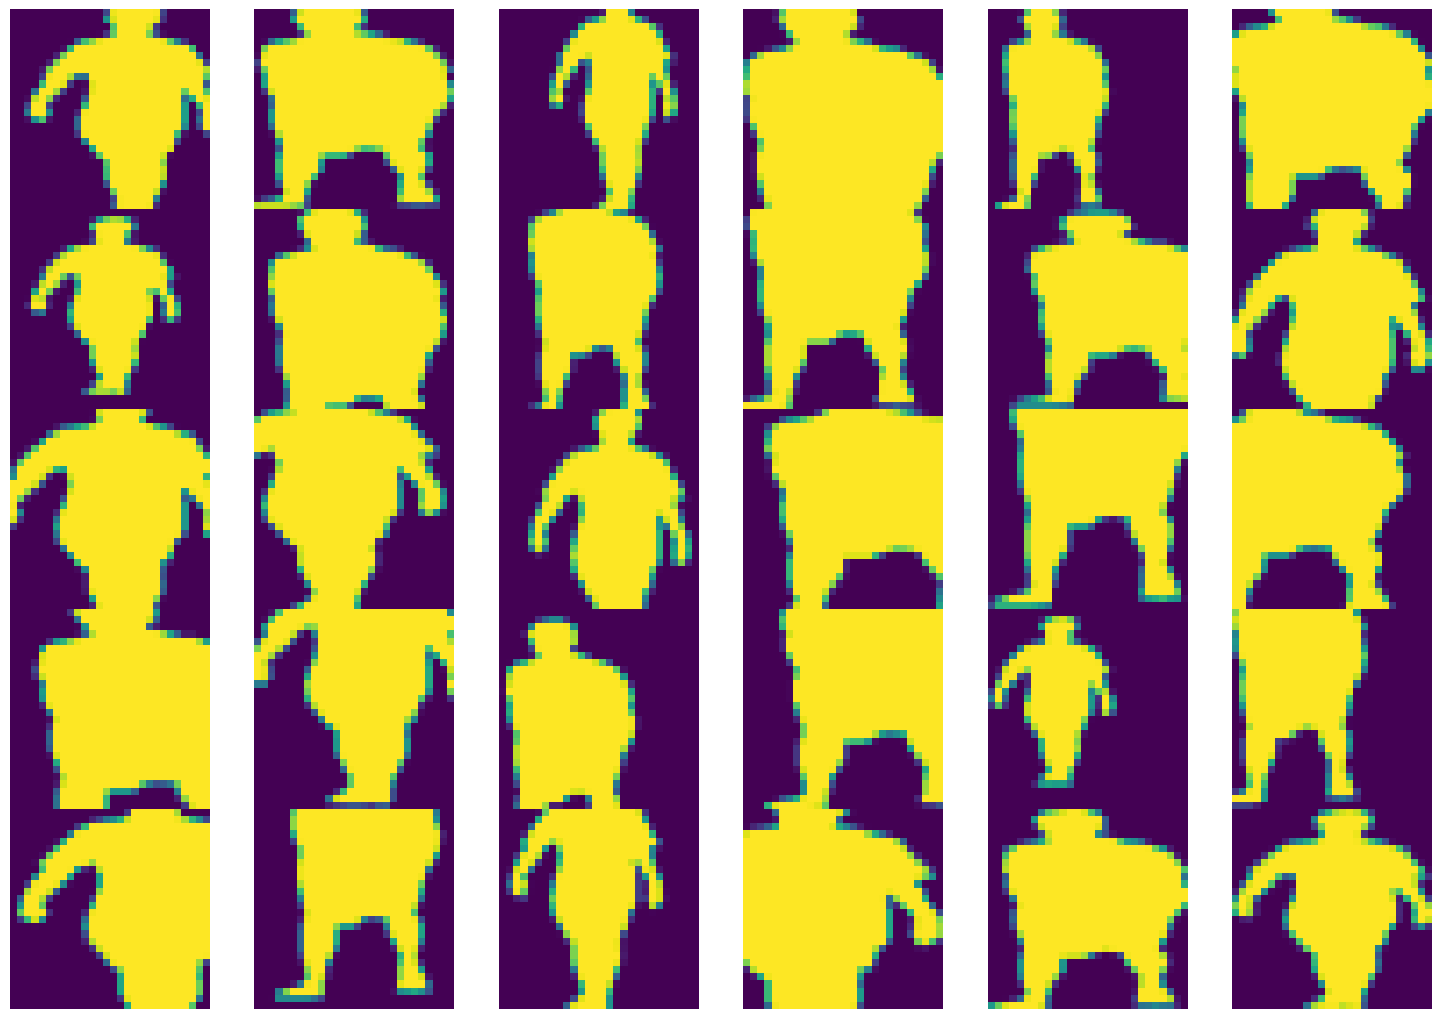

In [15]:
fig, axes=plt.subplots(5, 6, figsize=(15,10))
for i in range(5):
    for j in range(6):
        axes[i,j].imshow(predicted_mask.detach()[i*6+j])
        axes[i,j].axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig, axes=plt.subplots(5, 6, figsize=(15,10))
for i in range(5):
    for j in range(6):
        axes[i,j].imshow(reference_masks[i*6+j])
        axes[i,j].axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

[`maskrcnn_inference`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L56)

```
masks_probs = maskrcnn_inference(mask_logits, labels)
```

test

In [16]:
# testing 
mask_proposals=[p["boxes"] for p in box_predict_results['result']]
mask_features = model.roi_heads.mask_roi_pool(features, mask_proposals, tfm_inputs['tfm_images'].image_sizes)
mask_features = model.roi_heads.mask_head(mask_features)
mask_logits = model.roi_heads.mask_predictor(mask_features)
print('mask_logits ', mask_logits.shape)

labels=[r['labels'] for r in box_predict_results['result'] ]
print('mask_proposals ', [p.shape for p in mask_proposals])
print('labels ', [l.shape for l in labels])

mask_logits  torch.Size([200, 2, 28, 28])
mask_proposals  [torch.Size([100, 4]), torch.Size([100, 4])]
labels  [torch.Size([100]), torch.Size([100])]


In [17]:
def maskrcnn_inference(x:Tensor, labels:list[Tensor])->list[Tensor]:
    '''
    From results of CNN, post processing the masks by taking the mask corresponding to the class with max probablity 
    (which are of fixed size and directly output by the CNN) and return the masks in the mask field 
    Args:
        x (Tensor): NxLxHxW mask logits where L is the number of label
        labels (list[Tensor]): list of 1D labels 
    Returns:
        mask_prob (list[Tensor]): list of Nx1xHxW mask per images
    '''
    mask_prob=x.sigmoid() # NxLxHxW

    # select masks corresponding to the predicted classes
    num_masks=x.shape[0]
    boxes_per_image=[label.shape[0] for label in labels]
    labels=torch.cat(labels, dim=0) # N
    index=torch.arange(num_masks, device=labels.device)
    mask_prob=mask_prob[index, labels][:,None] # select only label=1 -> NxHxW -> Nx1xHxW
    mask_prob=mask_prob.split(boxes_per_image, dim=0)
    print([m.shape for m in mask_prob])
    return mask_prob

masks_probs = maskrcnn_inference(mask_logits, labels)

[torch.Size([100, 1, 28, 28]), torch.Size([100, 1, 28, 28])]


In [20]:
for mask_prob, r in zip(masks_probs,box_predict_results['result']) :
    r['masks']=mask_prob

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].


msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].


msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].


msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].


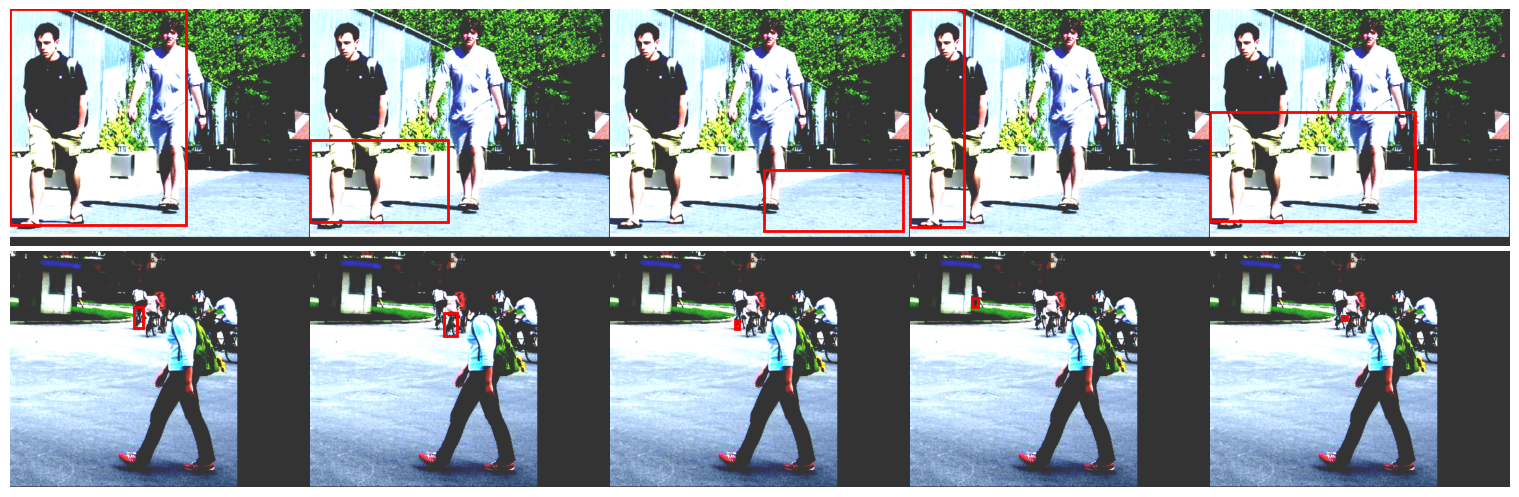

In [35]:
import matplotlib.patches as patches
outputs=box_predict_results['result'] 

topk=5
fig, axes=plt.subplots(len(outputs), topk, figsize=(15,5))
for im_idx, (output) in enumerate(outputs): 
    for k, (box, msk) in enumerate(zip(output['boxes'], output['masks'])):
        if k>=5: break
        msk=(msk>0.5).to(dtype=torch.uint8).squeeze()
        print('msk ', msk.shape, ' box ', box.shape)
        axes[im_idx, k].imshow(tfm_inputs['tfm_images'].tensors[im_idx].permute(1,2,0), alpha=0.8)
        # axes[im_idx, k].imshow(msk, alpha=0.1)
        width, height=[p-q for p, q in zip(box[2:].tolist(), box[:2].tolist())]
        rect = patches.Rectangle(box[:2].tolist(), width, height, linewidth=2, edgecolor='r', facecolor='none')
        axes[im_idx, k].add_patch(rect)
        axes[im_idx, k].axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].


msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].


msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].


msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])
msk  torch.Size([28, 28])  box  torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].


msk  torch.Size([28, 28])  box  torch.Size([4])


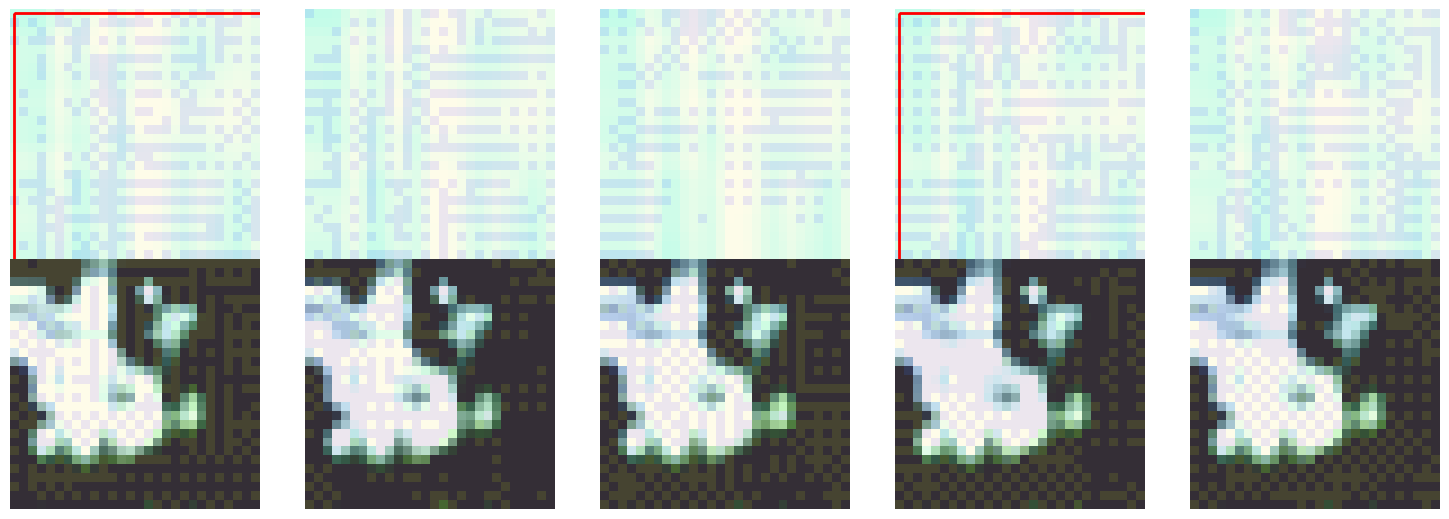

In [34]:
import matplotlib.patches as patches
outputs=box_predict_results['result'] 

topk=5
fig, axes=plt.subplots(len(outputs), topk, figsize=(15,5))
for im_idx, (output) in enumerate(outputs): 
    for k, (box, msk) in enumerate(zip(output['boxes'], output['masks'])):
        if k>=5: break
        msk=(msk>0.5).to(dtype=torch.uint8).squeeze()
        print('msk ', msk.shape, ' box ', box.shape)
        axes[im_idx, k].imshow(tfm_inputs['tfm_images'].tensors[im_idx].permute(1,2,0), alpha=0.8)
        axes[im_idx, k].imshow(msk, alpha=0.1)
        width, height=[p-q for p, q in zip(box[2:].tolist(), box[:2].tolist())]
        rect = patches.Rectangle(box[:2].tolist(), width, height, linewidth=2, edgecolor='r', facecolor='none')
        axes[im_idx, k].add_patch(rect)
        axes[im_idx, k].axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)